In [1]:
from google.colab import drive
import pickle as pkl
drive.mount('/content/drive')

train = pkl.load(open('/content/drive/MyDrive/IR_pickles/train_dict.pkl','rb'))

Mounted at /content/drive


In [2]:
import os
from zipfile import ZipFile

os.mkdir('Images')
with ZipFile("/content/drive/MyDrive/IR_pickles/All_Images.zip", 'r') as zObject:    
  zObject.extractall(path="Images")                                       

In [3]:
from google.colab import files
import pandas as pd

uploads=files.upload() 
df = pd.read_csv('Train.csv')
img_dir = "/content/Images/All_Images/"

Saving Train.csv to Train.csv


In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image
from operator import itemgetter


base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
ft_dict = dict()


def extract(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  feature = model.predict(x)[0]
  return feature / np.linalg.norm(feature)



def build_feature_dict():
  for fl in train.keys():
    if fl != "Adventure_sports_3_5363":
      fl_path = img_dir + fl + '.jpg'
      img = Image.open(fl_path)
      ft = extract(img)
      ft_dict[fl] = [train[fl][0],ft]



In [7]:
build_feature_dict()
fobj=open('feature_dict.pkl','wb')
pkl.dump(ft_dict,fobj)
fobj.close()
files.download('feature_dict.pkl')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Runtime code

In [ ]:
import pickle as pkl
from google.colab import files

uploads=files.upload() 
ft_dict = pkl.load(open('/content/feature_dict.pkl','rb'))

In [10]:
from scipy.spatial.distance import cosine
import operator
from operator import itemgetter


def get_sim_img(img):
  res = []
  ft = extract(img)
  for fl,train_ft in ft_dict.items():
    sim = 1-cosine(train_ft[1],ft)
    res.append([train_ft[0],train[fl][1],sim,train[fl][2]])
  res.sort(key = operator.itemgetter(2,3), reverse = True)
  if len(res) > 50:
    pids = [res[i][0] for i in range(50)]
    res = [[res[i][0],res[i][1]] for i in range(50)]
  else:
    pids = [res[i][0] for i in range(len(res))]
    res = [[res[i][0],res[i][1]]for i in range(len(res))]
  df2 = df.loc[pids]
  res_df = df2[['place_id', 'title', 'city', 'state', 'description', 'imageUrls_0']].copy()
  for i in range(len(res_df)):
    res_df['imageUrls_0'][i] = res[i][1]
  return res_df

##### Sample Image

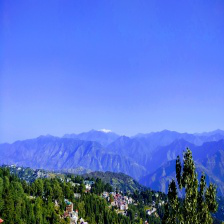

In [12]:
from PIL import Image

img_file = "/content/Tourist_attraction_5718.jpg"       # write the image file name
img = Image.open(img_file)
img.show()